In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import ipywidgets as widgets
from IPython.display import display

# Parameters
alpha = 0.05  # 95% CL
mu_true_max = 20
n_max = 40
mu_vals = np.linspace(0, mu_true_max, 200)
n_vals = np.arange(0, n_max+1)

# ----------------------------
# Feldman-Cousins Neyman belt
# ----------------------------
def feldman_cousins_belt(mu_vals, n_vals, alpha=0.05):
    belt = dict()
    for mu in mu_vals:
        p_n = poisson.pmf(n_vals, mu)
        mu_best = n_vals  # ML estimate
        p_n_best = poisson.pmf(n_vals, mu_best)
        R = p_n / p_n_best  # likelihood ratio ordering
        sort_idx = np.argsort(-R)
        cum_prob = 0
        selected_n = []
        for idx in sort_idx:
            n = n_vals[idx]
            selected_n.append(n)
            cum_prob += p_n[idx]
            if cum_prob >= 1-alpha:
                break
        belt[mu] = np.sort(selected_n)
    return belt

belt = feldman_cousins_belt(mu_vals, n_vals, alpha)

# ----------------------------
# Function to compute interval for observed n
# ----------------------------
def feldman_cousins_interval(n_obs, mu_vals, belt):
    included_mu = [mu for mu in mu_vals if n_obs in belt[mu]]
    if len(included_mu) == 0:
        return None, None
    return min(included_mu), max(included_mu)

# ----------------------------
# Interactive plotting function
# ----------------------------
def plot_fc_interactive(n_obs):
    plt.figure(figsize=(10,6))

    # Plot Neyman belt
    for mu in mu_vals[::5]:
        plt.plot([mu]*len(belt[mu]), belt[mu], 'b.', markersize=2)

    # Compute FC interval for observed n
    mu_low, mu_high = feldman_cousins_interval(n_obs, mu_vals, belt)

    if mu_low is not None:
        plt.axvspan(mu_low, mu_high, color='orange', alpha=0.3, label=f'FC 95% CL interval for n={n_obs}')

    # Highlight observed n
    plt.axhline(n_obs, color='red', linestyle='--', label=f'Observed n={n_obs}')

    plt.xlabel(r'True $\mu$')
    plt.ylabel('Observed n')
    plt.title('Feldman-Cousins Neyman Belt (Poisson, 95% CL)')
    plt.legend()
    plt.grid(True)
    plt.show()

    if mu_low is not None:
        print(f"Observed n = {n_obs}, Feldman-Cousins 95% CL interval: [{mu_low:.2f}, {mu_high:.2f}]")
    else:
        print(f"No interval found for n = {n_obs}")

# ----------------------------
# Interactive slider
# ----------------------------
n_slider = widgets.IntSlider(value=3, min=0, max=n_max, step=1, description='Observed n:')
widgets.interact(plot_fc_interactive, n_obs=n_slider)

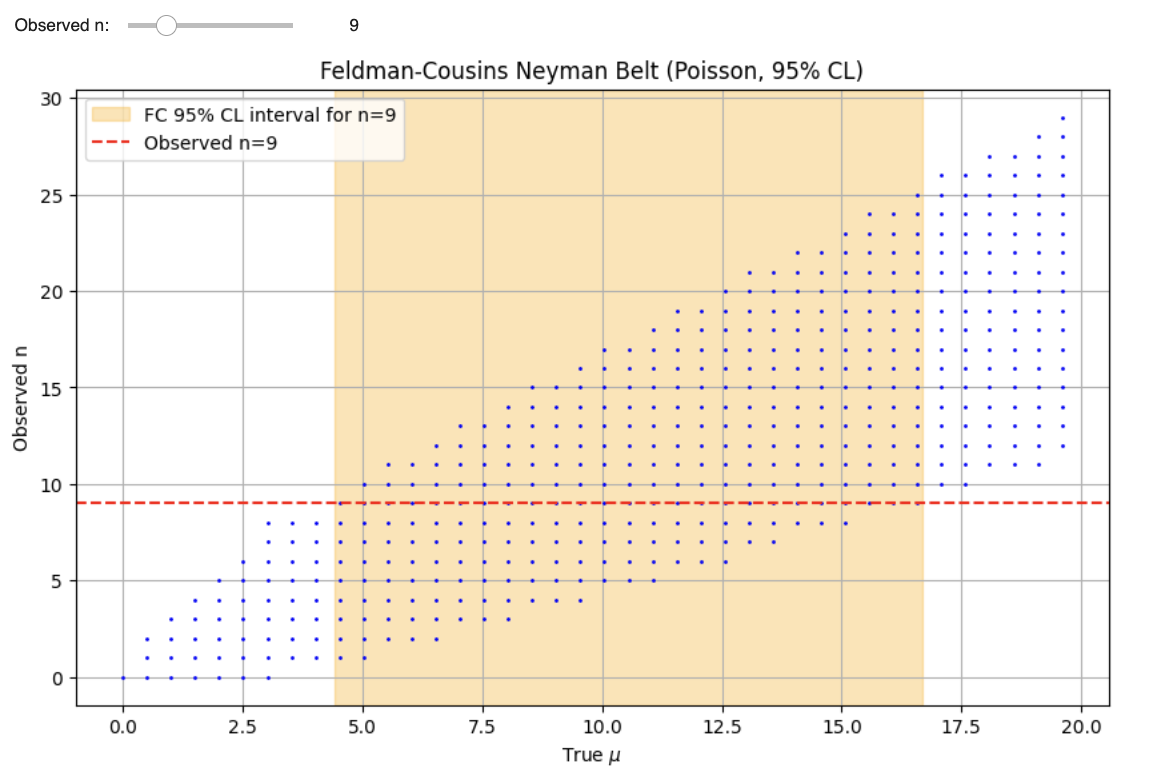

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, chi2
import ipywidgets as widgets
from IPython.display import display

# Parameters
alpha = 0.05  # 95% CL
mu_true_max = 20
n_max = 40
mu_vals = np.linspace(0, mu_true_max, 200)
n_vals = np.arange(0, n_max+1)

# ----------------------------
# Feldman-Cousins Neyman belt
# ----------------------------
def feldman_cousins_belt(mu_vals, n_vals, alpha=0.05):
    belt = dict()
    for mu in mu_vals:
        p_n = poisson.pmf(n_vals, mu)
        mu_best = n_vals
        p_n_best = poisson.pmf(n_vals, mu_best)
        R = p_n / p_n_best
        sort_idx = np.argsort(-R)
        cum_prob = 0
        selected_n = []
        for idx in sort_idx:
            n = n_vals[idx]
            selected_n.append(n)
            cum_prob += p_n[idx]
            if cum_prob >= 1-alpha:
                break
        belt[mu] = np.sort(selected_n)
    return belt

belt = feldman_cousins_belt(mu_vals, n_vals, alpha)

# ----------------------------
# FC interval for observed n
# ----------------------------
def feldman_cousins_interval(n_obs, mu_vals, belt):
    included_mu = [mu for mu in mu_vals if n_obs in belt[mu]]
    if len(included_mu) == 0:
        return None, None
    return min(included_mu), max(included_mu)

# ----------------------------
# Plotting function
# ----------------------------
def plot_all_intervals(n_obs):
    # ----------------------------
    # Frequentist CI
    ci_lower = 0.5 * chi2.ppf(alpha/2, 2*n_obs)
    ci_upper = 0.5 * chi2.ppf(1-alpha/2, 2*(n_obs+1))

    # Bayesian CI (flat prior)
    posterior = gamma(a=n_obs+1, scale=1.0)
    bayes_lower = posterior.ppf(alpha/2)
    bayes_upper = posterior.ppf(1-alpha/2)

    # Feldman-Cousins interval
    fc_low, fc_high = feldman_cousins_interval(n_obs, mu_vals, belt)

    # ----------------------------
    # Plot
    plt.figure(figsize=(12,6))

    # Posterior
    lambda_vals = np.linspace(0, max(ci_upper, bayes_upper, fc_high if fc_high else 0)+5, 500)
    plt.plot(lambda_vals, posterior.pdf(lambda_vals), label='Posterior (Bayesian)', color='purple')

    # Bayesian CI
    plt.axvline(bayes_lower, color='purple', linestyle='--', label='Bayesian 95% CI')
    plt.axvline(bayes_upper, color='purple', linestyle='--')

    # Frequentist CI
    plt.axvline(ci_lower, color='green', linestyle=':', label='Frequentist 95% CI')
    plt.axvline(ci_upper, color='green', linestyle=':')

    # Feldman-Cousins
    if fc_low is not None:
        plt.axvspan(fc_low, fc_high, color='orange', alpha=0.3, label='Feldman-Cousins 95% CI')

    plt.title(f'Comparison of Intervals for Observed n = {n_obs}')
    plt.xlabel(r'True $\mu$ (particle rate)')
    plt.ylabel('Probability density / Interval')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print intervals
    print(f"Observed n = {n_obs}")
    print(f"Frequentist 95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"Bayesian 95% Credible Interval: [{bayes_lower:.2f}, {bayes_upper:.2f}]")
    if fc_low is not None:
        print(f"Feldman-Cousins 95% CL interval: [{fc_low:.2f}, {fc_high:.2f}]")
    else:
        print(f"Feldman-Cousins interval not found for n = {n_obs}")

# ----------------------------
# Interactive slider
# ----------------------------
n_slider = widgets.IntSlider(value=3, min=0, max=n_max, step=1, description='Observed n:')
widgets.interact(plot_all_intervals, n_obs=n_slider)

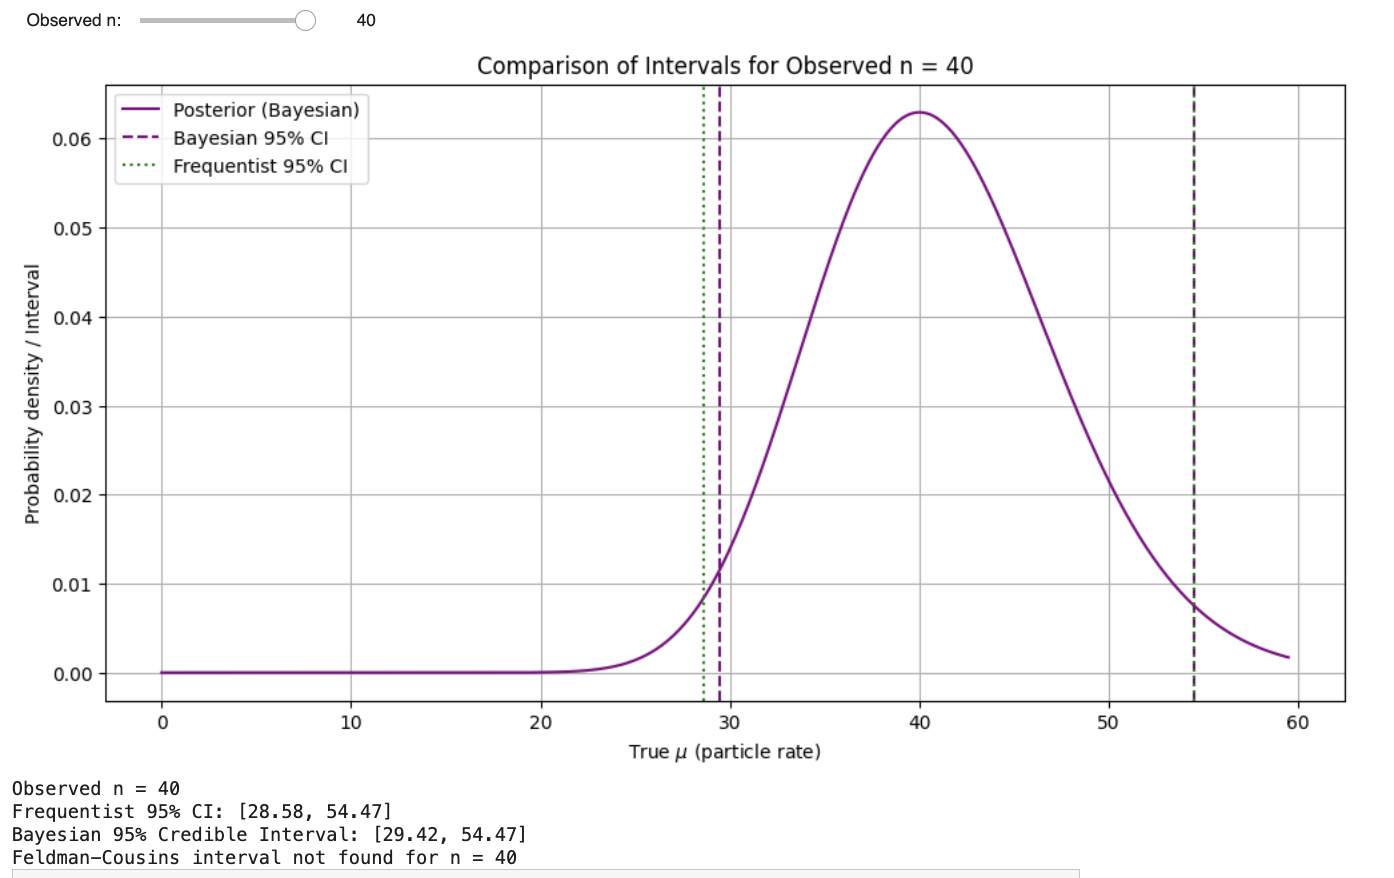
